# Incoming Tourism Data Analysis for Latvia  

### Final project for SheGoesTech Accenture Bootcamp

May, 2023

Welcome to our project on analyzing incoming tourism data for Latvia. Our goal is to gain insights into the demographics and spending habits of tourists visiting Latvia and to identify any trends or changes over time. 

To achieve this, we will be using various technologies such as numpy, pandas, matplotlib, and seaborn to analyze and visualize the data. Additionally, we will be using pyscbwrapper to access statistical data related to tourism in Latvia.

Project authors:  
    <ul>
    <li> Tatjana Sporihina </li> 
    <li> Kristiāna Gaņa </li>
    </ul>

In [1]:
pip install pyscbwrapper

Note: you may need to restart the kernel to use updated packages.


In [1]:
from pyscbwrapper import SCB
#IMPORTANT: the file scb.py in the package folder must be replaced with the one from the link below 
#https://stat.gov.lv/lv/api-un-kodu-vardnicas/api 

In [2]:
import pandas as pd 

### Data tables for incoming tourists 

In [3]:
#Creating SCB objects for each table 
#Example URL: https://data.stat.gov.lv:443/api/v1/lv/OSP_PUB/START/NOZ/TU/TUA/TUA030 
tua030 = SCB('en', 'NOZ', 'TU', 'TUA', 'TUA030') #Expenditures by country and avg trip length 
tua010 = SCB('en', 'NOZ', 'TU', 'TUA', 'TUA010') #Single and multi day travellers by countries 
tua050 = SCB('en', 'NOZ', 'TU', 'TUA', 'TUA050') #Goals of travellers 
tua070 = SCB('en', 'NOZ', 'TU', 'TUA', 'TUA070') #Split by age and gender

In [4]:
#List of tables we want for incoming tourism
tables = [tua030, tua010, tua050, tua070]

#Dictionary with resulting dataframes 
dfs = {}

for i,table in enumerate(tables):
    #Fetching params of each table 
    param = table.info()['variables'][0]['code']
    main_dimension = []
    metrics = []
    metrics_labels = []
    years = []
    countries = []

    for variable in table.info()['variables']:
        if variable['code'] == param:
            main_dimension = variable['values']
            
        if variable['code'] == 'COUNTRY':
            countries = variable['values']

        if variable['code'] == 'ContentsCode':
            metrics = variable['values']
            metrics_labels = variable['valueTexts']

        if variable['code'] == 'TIME':
            years = variable['values'][-10:]
    # Making queries
    if param == 'COUNTRY':
        table.set_query(COUNTRY = main_dimension, TIME = years, ContentsCode = metrics)
    elif param =='NON_RES_TRAVEL':
        table.set_query(NON_RES_TRAVEL = main_dimension, COUNTRY = countries, TIME = years, ContentsCode = metrics)
    elif param =='PURPOSE_TRIP':
        table.set_query(PURPOSE_TRIP = main_dimension, COUNTRY = countries, TIME = years, ContentsCode = metrics)
    elif param =='INDICATOR':
        table.set_query(INDICATOR = main_dimension, COUNTRY = countries, TIME = years, ContentsCode = metrics)
    table.get_query()
    table.get_data()
    scb_data = table.get_data()
    scb_fetch = scb_data['data']
    scb_fetch
    
    #Converting to a dataframe 
    df = pd.DataFrame.from_records(scb_fetch)
    df_name = f"df{i+1}"
    if len(df['key'][0]) == 2: 
          df[[param.title(), 'Year']] = pd.DataFrame(df['key'].tolist())
    elif len(df['key'][0]) == 3: 
          df[[param.title(), 'Country', 'Year']] = pd.DataFrame(df['key'].tolist())
    df[metrics_labels] = pd.DataFrame(df['values'].tolist())
    df = df.drop(columns=['key', 'values'])
    df.replace('…', 0, inplace=True)
    df.replace('-', 0, inplace=True)
    df['Year'] = pd.to_numeric(df['Year'])
    df.iloc[:, 2:] = df.iloc[:, 2:].astype(float)
        
    #Adding to a dictionary 
    dfs[df_name] = df

In [5]:
tua030 = dfs['df1']
tua010 = dfs['df2']
tua050 = dfs['df3']
tua070 = dfs['df4']

In [6]:
tua030.head()
#tua030.to_csv('tua030.csv')

,Country,Year,"Total expenditures of non-resident visitors, million euro","Average daily expenditure per non-resident traveller, euro","Average length of trips, nights"
0,TOTAL,2012,438.1,75.0,4.0
1,TOTAL,2013,481.5,68.6,4.6
2,TOTAL,2014,516.9,66.0,4.2
3,TOTAL,2015,540.8,66.3,4.0
4,TOTAL,2016,474.4,54.1,4.9


In [7]:
tua010.head()
#tua010.to_csv('tua010.csv')

,Non_Res_Travel,Country,Year,Non-resident travellers (thousands)
0,ARRIVALS,TOTAL,2012.0,5568.9
1,ARRIVALS,TOTAL,2013.0,5821.8
2,ARRIVALS,TOTAL,2014.0,6245.9
3,ARRIVALS,TOTAL,2015.0,6841.7
4,ARRIVALS,TOTAL,2016.0,6797.0


In [8]:
tua050.tail()
#tua050.to_csv('tua050.csv')

,Purpose_Trip,Year,Non-resident travellers (thousands)
65,TRANSIT,2017,2619.3
66,TRANSIT,2018,2691.7
67,TRANSIT,2019,3108.3
68,TRANSIT,2020,1242.6
69,TRANSIT,2021,1009.7


In [9]:
tua070.tail(10)
#tua070.to_csv('tua070.csv')

,Indicator,Year,Structure of non-resident travellers
70,Y_GE65,2012,5.4
71,Y_GE65,2013,6.4
72,Y_GE65,2014,4.2
73,Y_GE65,2015,4.2
74,Y_GE65,2016,4.7
75,Y_GE65,2017,3.1
76,Y_GE65,2018,5.0
77,Y_GE65,2019,2.7
78,Y_GE65,2020,2.0
79,Y_GE65,2021,1.9


# Incoming tourism analysis

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

In [11]:
tua010['Year'] = tua010['Year'].astype(int)
#Total data 
tua030_total = tua030[tua030['Country'] == 'TOTAL']
tua010_total = tua010[(tua010['Country'] == 'TOTAL') & (tua010['Non_Res_Travel'] == 'ARRIVALS')]
tua030_total.head()

,Country,Year,"Total expenditures of non-resident visitors, million euro","Average daily expenditure per non-resident traveller, euro","Average length of trips, nights"
0,TOTAL,2012,438.1,75.0,4.0
1,TOTAL,2013,481.5,68.6,4.6
2,TOTAL,2014,516.9,66.0,4.2
3,TOTAL,2015,540.8,66.3,4.0
4,TOTAL,2016,474.4,54.1,4.9


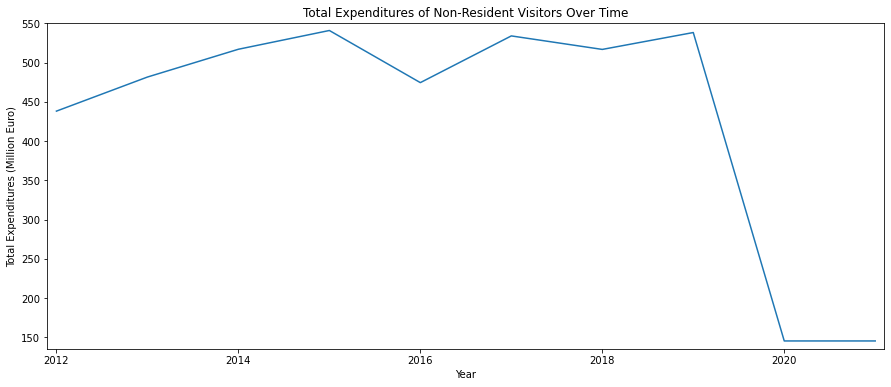

In [12]:
plt.figure(figsize=(15,6));
plt.plot(tua030_total["Year"], tua030_total["Total expenditures of non-resident visitors, million euro"])

plt.xlabel("Year")
plt.ylabel("Total Expenditures (Million Euro)")
plt.title("Total Expenditures of Non-Resident Visitors Over Time")
plt.xlim(min(tua030_total["Year"])-0.1, max(tua030_total["Year"])+0.1)
plt.ylim(min(tua030_total["Total expenditures of non-resident visitors, million euro"])-10, 
         max(tua030_total["Total expenditures of non-resident visitors, million euro"])+10)
plt.show()

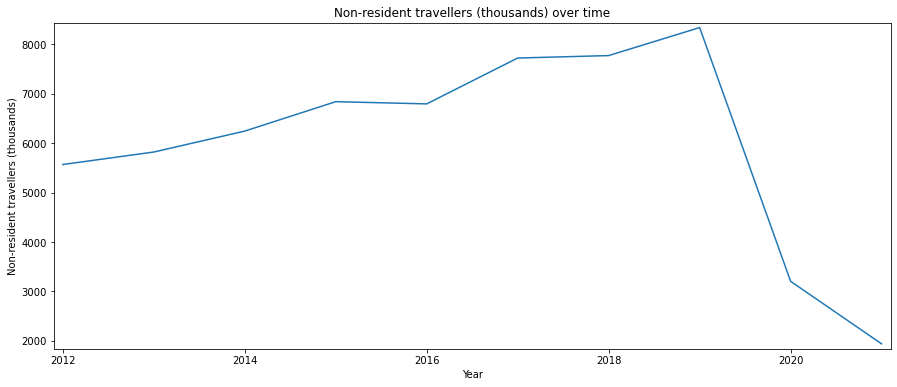

In [13]:
plt.figure(figsize=(15,6));
plt.plot(tua010_total["Year"], tua010_total["Non-resident travellers (thousands)"])

plt.xlabel("Year")
plt.ylabel("Non-resident travellers (thousands)")
plt.title("Non-resident travellers (thousands) over time")
plt.xlim(min(tua010_total["Year"])-0.1, max(tua010_total["Year"])+0.1)
plt.ylim(min(tua010_total["Non-resident travellers (thousands)"])-100, 
         max(tua010_total["Non-resident travellers (thousands)"])+100)
plt.show()

In [33]:
#Data split across countries 
tua030_agg = tua030[tua030['Country'] != 'TOTAL']
tua010_agg = tua010[(tua010['Country']!= 'TOTAL') & (tua010['Non_Res_Travel'] == 'ARRIVALS') 
                    & (~tua010['Country'].str.contains('EU')) & (~tua010['Country'].str.contains('CIS'))]
tua010_agg.head()

,Non_Res_Travel,Country,Year,Non-resident travellers (thousands)
10,ARRIVALS,US,2012.0,41.4
11,ARRIVALS,US,2013.0,41.5
12,ARRIVALS,US,2014.0,30.3
13,ARRIVALS,US,2015.0,0.0
14,ARRIVALS,US,2016.0,52.7


In [15]:
#Top 10 countries with largest expenditures 
tua030_metric = tua030_agg.groupby(['Country']).sum()[['Total expenditures of non-resident visitors, million euro']]
tua030_metric_10 = tua030_metric['Total expenditures of non-resident visitors, million euro'].nlargest(10)
others = tua030[tua030['Country'] == 'TOTAL']['Total expenditures of non-resident visitors, million euro'].sum() - tua030_agg.groupby(['Country']).sum()['Total expenditures of non-resident visitors, million euro'].sum()
others_total = tua030_metric.loc[~tua030_metric.index.isin(tua030_metric_10.index), 'Total expenditures of non-resident visitors, million euro'].sum()
tua030_metric_10 = tua030_metric_10.append(pd.Series({'Others': others + others_total}))

In [16]:
#Top 10 countries with largest number of travellers
tua010_metric = tua010_agg.groupby(['Country']).sum()[['Non-resident travellers (thousands)']]
tua010_metric_10 = tua010_metric['Non-resident travellers (thousands)'].nlargest(10)
others_ =  tua010_total['Non-resident travellers (thousands)'].sum() - tua010_metric['Non-resident travellers (thousands)'].sum() 
others_total_ = tua010_metric.loc[~tua010_metric.index.isin(tua010_metric_10.index), 'Non-resident travellers (thousands)'].sum()
tua010_metric_10 = tua010_metric_10.append(pd.Series({'Others': others_ + others_total_}))

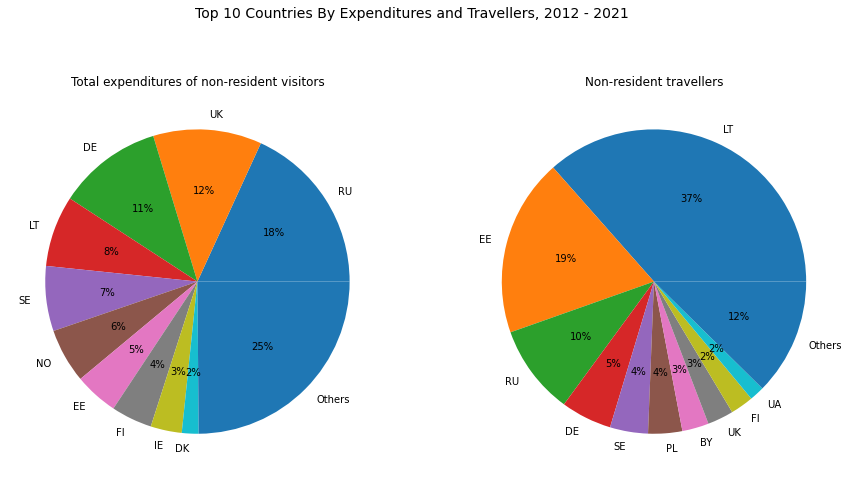

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

ax1.pie(tua030_metric_10, labels=tua030_metric_10.index, autopct='%1.f%%')
ax1.set_title('Total expenditures of non-resident visitors')

ax2.pie(tua010_metric_10, labels=tua010_metric_10.index, autopct='%1.f%%')
ax2.set_title('Non-resident travellers')

plt.suptitle('Top 10 Countries By Expenditures and Travellers, 2012 - 2021', fontsize = 14)
plt.show()

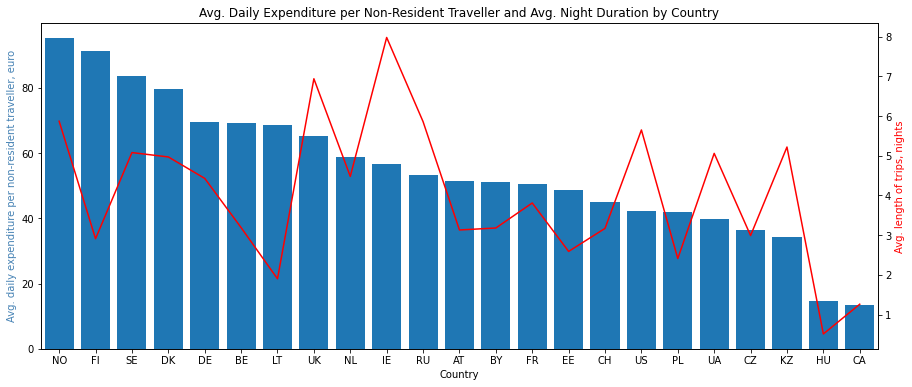

In [73]:
grouped_tua030_agg = tua030_agg.groupby('Country').mean().sort_values('Average daily expenditure per non-resident traveller, euro', ascending = False)

fig, ax1 = plt.subplots(figsize=(15, 6))
ax2 = ax1.twinx()

ax1.bar(grouped_tua030_agg.index, grouped_tua030_agg['Average daily expenditure per non-resident traveller, euro'])
ax1.set_xlabel('Country')
ax1.set_ylabel('Avg. daily expenditure per non-resident traveller, euro', color = 'steelblue')
ax1.set_title('Avg. Daily Expenditure per Non-Resident Traveller and Avg. Night Duration by Country')
num_bars = len(grouped_tua030_agg.index)
ax1.set_xlim(xmin=-0.5, xmax=num_bars-0.5)

ax2.plot(grouped_tua030_agg.index, grouped_tua030_agg['Average length of trips, nights'], color='red')
ax2.set_ylabel('Avg. length of trips, nights', color ='red');


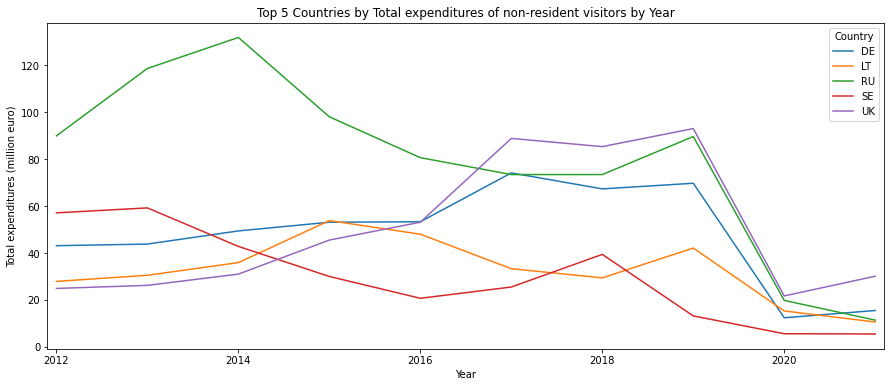

In [19]:
#Top 5 countries dynamics: expenditure 
tua030_grouped = tua030_agg.groupby(['Country', 'Year']).sum()
tua030_largest = tua030_grouped.groupby('Country').sum().nlargest(5, 'Total expenditures of non-resident visitors, million euro').index
tua030_filtered = tua030[tua030['Country'].isin(tua030_largest)]
tua030_pivot = tua030_filtered.pivot(index='Year', columns='Country', values='Total expenditures of non-resident visitors, million euro')
tua030_pivot.plot(kind='line', figsize=(15,6))
plt.title('Top 5 Countries by Total expenditures of non-resident visitors by Year')
plt.xlabel('Year')
plt.ylabel('Total expenditures (million euro)')
plt.xlim(min(tua030_total["Year"])-0.1, max(tua030_total["Year"])+0.1)
plt.show()

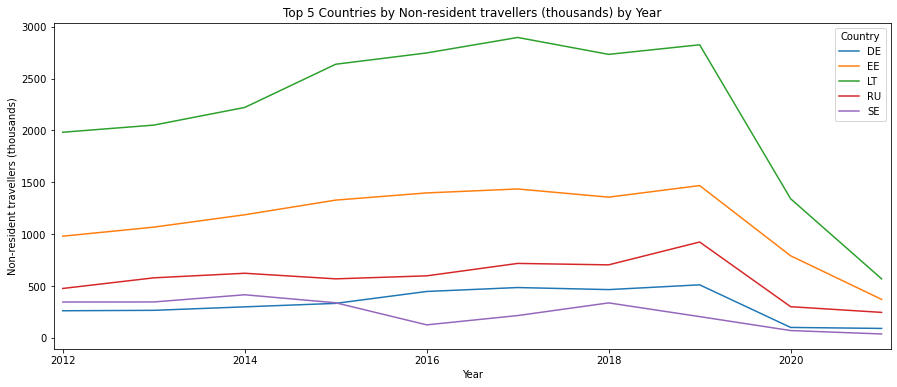

In [20]:
#Top 5 countries dynamics arrivals 
tua010_grouped = tua010_agg.groupby(['Country', 'Year']).sum()
tua010_largest = tua010_grouped.groupby('Country').sum().nlargest(5, 'Non-resident travellers (thousands)').index
tua010_filtered = tua010_agg[tua010_agg['Country'].isin(tua010_largest)]
tua010_pivot = tua010_filtered.pivot(index='Year', columns='Country', values='Non-resident travellers (thousands)')
tua010_pivot.plot(kind='line', figsize=(15,6))
plt.title('Top 5 Countries by Non-resident travellers (thousands) by Year')
plt.xlabel('Year')
plt.ylabel('Non-resident travellers (thousands)')
plt.xlim(min(tua010_total["Year"])-0.1, max(tua010_total["Year"])+0.1)
plt.show()

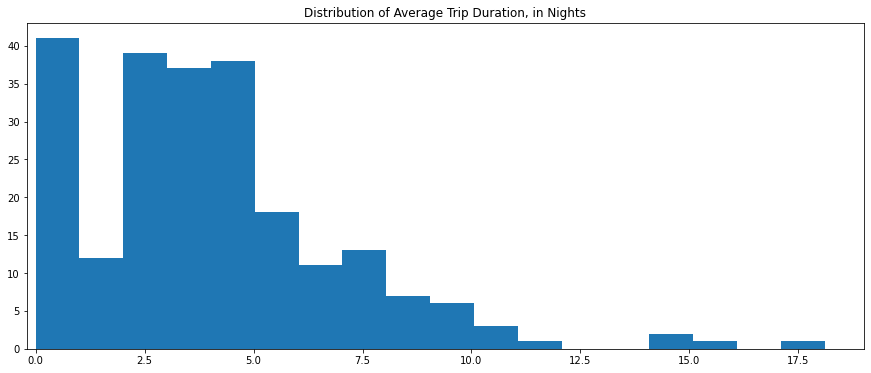

In [21]:
plt.figure(figsize=(15,6))
plt.hist(tua030_agg['Average length of trips, nights'], bins=18)
plt.xlim(xmin=-0.2)
plt.title('Distribution of Average Trip Duration, in Nights');

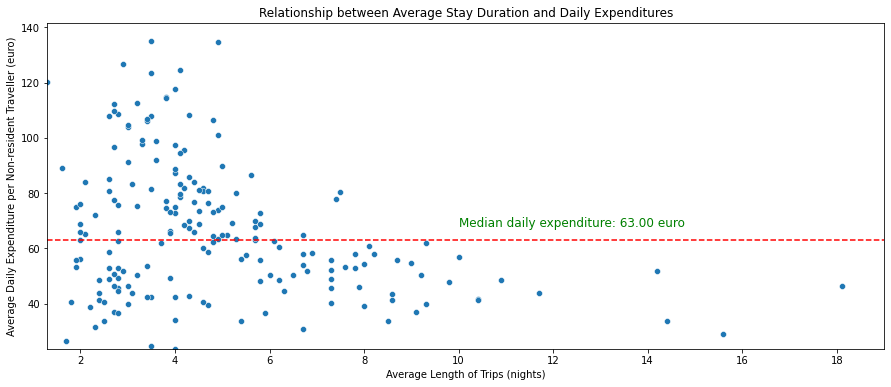

In [22]:
data = tua030_agg
plt.figure(figsize=(15, 6))

# Create scatter plot
sns.scatterplot(y='Average daily expenditure per non-resident traveller, euro', x='Average length of trips, nights', data=data)

# Set x and y-axis limits
plt.ylim(ymin = data[data['Average daily expenditure per non-resident traveller, euro']!=0]['Average daily expenditure per non-resident traveller, euro'].min())
plt.xlim(xmin = data[data['Average length of trips, nights']!=0]['Average length of trips, nights'].min())

# Set x and y labels
plt.ylabel('Average Daily Expenditure per Non-resident Traveller (euro)')
plt.xlabel('Average Length of Trips (nights)')
plt.title("Relationship between Average Stay Duration and Daily Expenditures")

median_expenditure = np.median(data[data['Average daily expenditure per non-resident traveller, euro']!=0]['Average daily expenditure per non-resident traveller, euro'])
plt.axhline(y=median_expenditure, color='r', linestyle='--')
plt.text(10, median_expenditure + 5, f'Median daily expenditure: {median_expenditure:.2f} euro', color='green', fontsize=12)
# Show plot
plt.show()

In [23]:
#Removing regions and total 
tua010_filtered = tua010[(tua010['Country']!= 'TOTAL') & (~tua010['Country'].str.contains('EU')) & (~tua010['Country'].str.contains('CIS'))]

#Creating a pivot table 
pivot_table_010 = pd.pivot_table(tua010_filtered, values=['Non-resident travellers (thousands)'], index=['Country'], 
                                 columns=['Non_Res_Travel'], aggfunc = 'sum')
tua010_flat = pivot_table_010
tua010_flat.columns = tua010_flat.columns.get_level_values(1)
tua010_flat['SINGLE DAY'] = tua010_flat['ARRIVALS'] - tua010_flat['ARRIVALS_OVERNIGHT']
tua010_flat = tua010_flat.rename(columns = {'ARRIVALS': 'TOTAL', 'ARRIVALS_OVERNIGHT': 'MULTIDAY'})
tua010_flat = tua010_flat.sort_values("TOTAL", ascending = False)
tua010_flat.head()

Non_Res_Travel,TOTAL,MULTIDAY,SINGLE DAY
Country,,,
LT,22008.1,2554.2,19453.9
EE,11383.2,1707.8,9675.4
RU,5735.9,2399.9,3336.0
DE,3257.7,1641.7,1616.0
SE,2434.2,972.6,1461.6


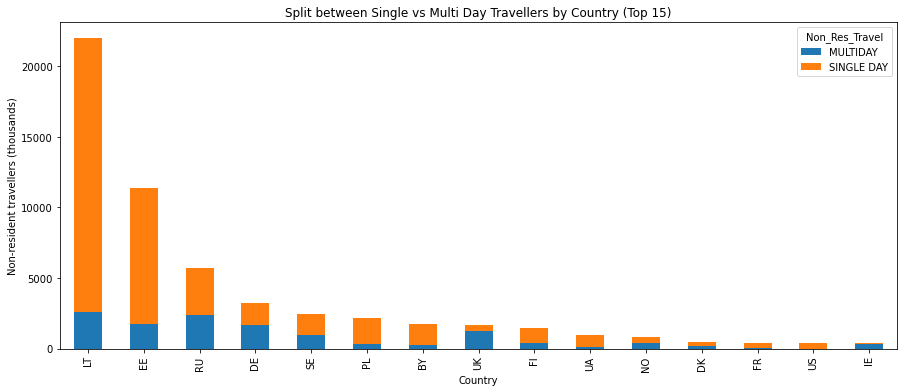

In [24]:
tua010_flat[['MULTIDAY', 'SINGLE DAY']][:15].plot(kind='bar', stacked=True, figsize=(15, 6), 
                                                  ylabel = 'Non-resident travellers (thousands)', 
                                                  title = 'Split between Single vs Multi Day Travellers by Country (Top 15)'); 

#In CSB, single day visitors mean people who didn't stay in hotels or registered tourism accomodations 

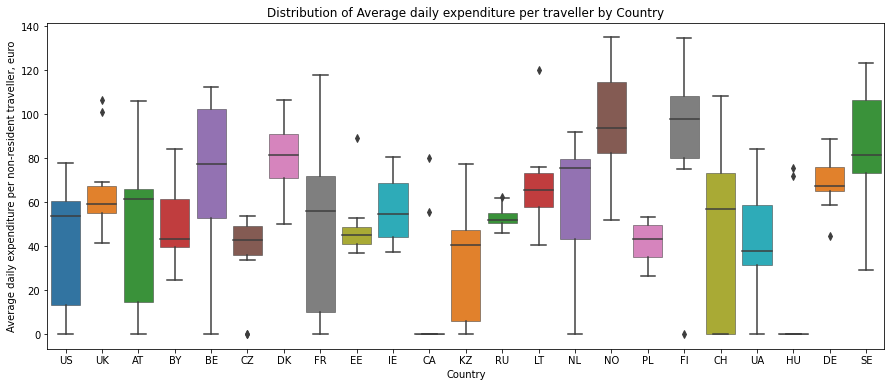

In [74]:
plt.figure(figsize=(15, 6))

sns.boxplot(data = tua030_agg, x = 'Country', y = 'Average daily expenditure per non-resident traveller, euro', 
            palette = 'tab10', boxprops=dict(linewidth=0.5))
plt.title('Distribution of Average daily expenditure per traveller by Country');

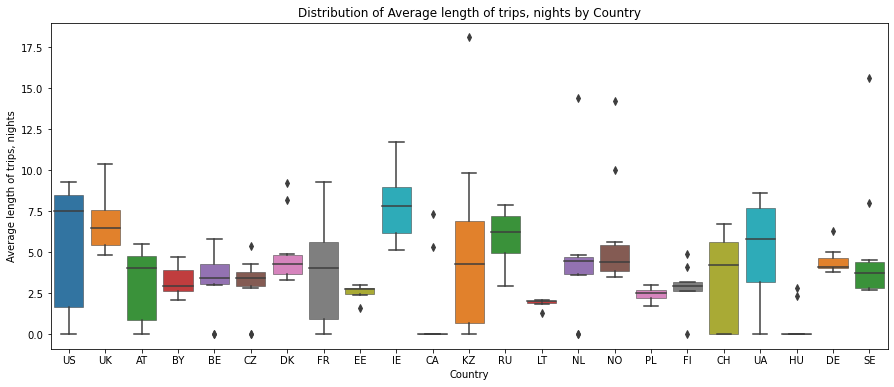

In [75]:
plt.figure(figsize=(15, 6))
sns.boxplot(data = tua030_agg, x = 'Country', y = 'Average length of trips, nights', palette = 'tab10', boxprops=dict(linewidth=0.5))
plt.title('Distribution of Average length of trips, nights by Country');

In [10]:
# Main travel objectives (stacked columns by years or others)
# Removing "TOTAL" values from the imported table
tua050_data = tua050.drop([0,1,2,3,4,5,6,7,8,9]) 

In [17]:
pivot_table_050 = pd.pivot_table(tua050_data, values=['Non-resident travellers (thousands)'], index=['Purpose_Trip'], columns=['Year'], aggfunc = 'sum')
tua050_flat = pivot_table_050
tua050_flat.columns = tua050_flat.columns.get_level_values(1)
tua050_flat.head()
# PERS_HOL is Holidays, leisure and recreation
# PERS_OTH is Other personal purpose
# PERS_PROF is Recreational, other private and business trips
# PERS_VFR is Visiting friends, relatives
# PROF is Professional/business purpose

Year,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Purpose_Trip,,,,,,,,,,
PERS_HOL,1243.3,1687.0,2482.0,2946.6,2611.6,1948.9,2048.3,2104.5,499.4,269.6
PERS_OTH,2790.3,2531.4,1964.5,1983.9,2481.7,3829.3,3832.3,4377.9,1930.9,1238.6
PERS_PROF,2778.6,3290.4,4281.4,4857.9,4315.3,3896.5,3942.9,3967.0,1272.6,698.2
PERS_VFR,794.5,901.0,1071.6,1108.8,1019.9,1211.0,1217.0,1173.5,447.3,278.5
PROF,740.8,702.4,727.8,802.5,683.6,736.6,677.6,689.0,326.0,150.0


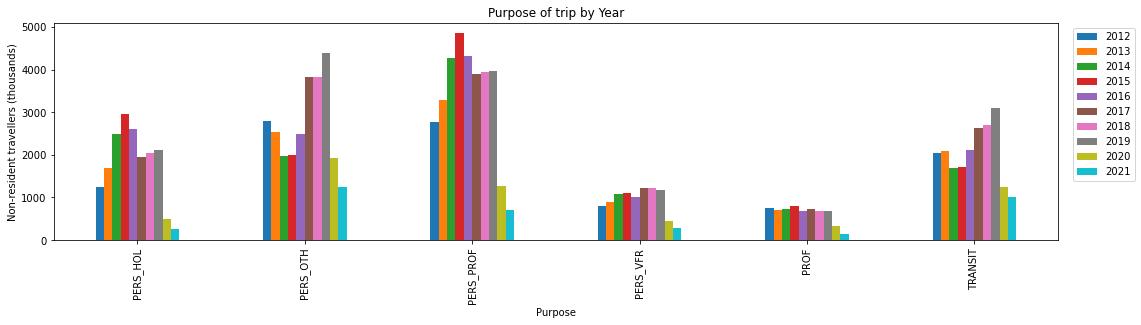

In [22]:
tua050_flat.plot(kind='bar', figsize=(18, 4))
plt.title('Purpose of trip by Year')
plt.xlabel('Purpose')
plt.ylabel('Non-resident travellers (thousands)')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

In [25]:
# Diagram for ages and genders, dataframe tua070.
# Removing "TOTAL" values from the imported table
tua070_data = tua070.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
pivot_table_070 = pd.pivot_table(tua070_data, values=['Structure of non-resident travellers'], index=['Year'], columns=['Indicator'], aggfunc = 'sum')
tua070_flat = pivot_table_070
tua070_flat.columns = tua070_flat.columns.get_level_values(1)
tua070_flat.head()

Indicator,F,M,Y15-24,Y25-44,Y45-64,Y_GE65
Year,,,,,,
2012,29.7,70.3,9.6,45.3,39.7,5.4
2013,30.0,70.0,9.2,47.2,37.2,6.4
2014,30.5,69.5,9.9,52.4,33.5,4.2
2015,32.3,67.7,10.0,53.2,32.6,4.2
2016,34.3,65.7,13.5,52.6,29.2,4.7


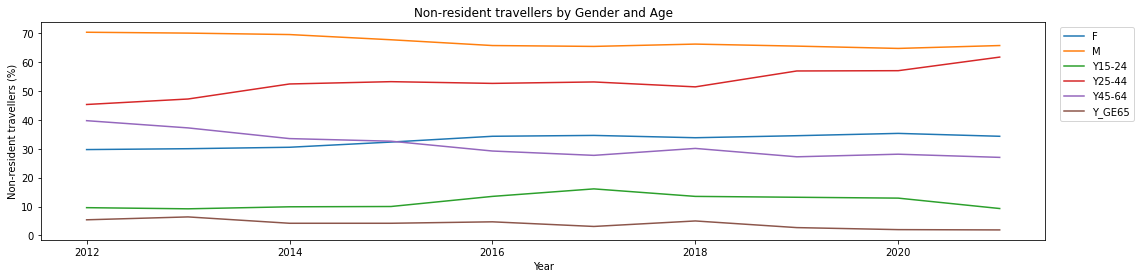

In [26]:
tua070_flat.plot(kind='line', figsize=(18,4)) 
plt.title('Non-resident travellers by Gender and Age')
plt.xlabel('Year')
plt.ylabel('Non-resident travellers (%)')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

In [27]:
tua070.Indicator.unique()
groups_age = [ 'Y15-24', 'Y25-44', 'Y45-64', 'Y_GE65']
groups_gender = ['M', 'F']
#Pivot for age
tua070_groups_age = tua070[tua070.Indicator.isin(groups_age)].reset_index(drop = True)
tua070_groups_age_pivot = pd.pivot(tua070_groups_age, values=['Structure of non-resident travellers'], index=['Year'], 
                                 columns=['Indicator'])
tua070_groups_age_pivot.columns = tua070_groups_age_pivot.columns.get_level_values(1)

#Pivot for gender
tua070_groups_gender = tua070[tua070.Indicator.isin(groups_gender)].reset_index(drop = True)
tua070_groups_gender_pivot = pd.pivot(tua070_groups_gender, values=['Structure of non-resident travellers'], index=['Year'], 
                                 columns=['Indicator'])   

tua070_groups_gender_pivot.columns = tua070_groups_gender_pivot.columns.get_level_values(1)

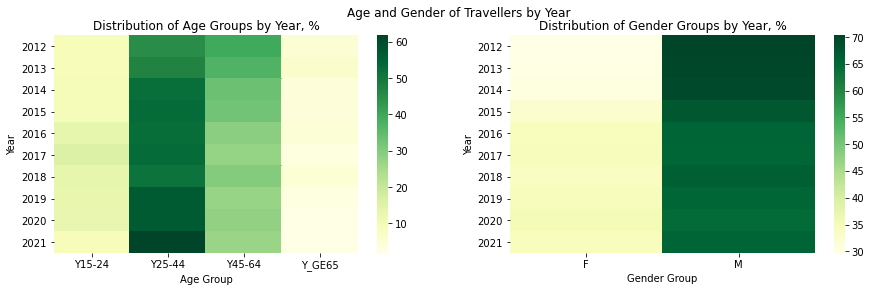

In [63]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
sns.heatmap(tua070_groups_age_pivot, cmap= 'YlGn')
plt.title("Distribution of Age Groups by Year, %")
plt.xlabel("Age Group")
plt.ylabel("Year")

plt.subplot(1,2,2)
sns.heatmap(tua070_groups_gender_pivot, cmap= 'YlGn')
plt.title("Distribution of Gender Groups by Year, %")
plt.xlabel("Gender Group")
plt.ylabel("Year")

plt.suptitle('Age and Gender of Travellers by Year');

## Conclusions

<ol>
<li>Despite a steady increase in the number of travelers, reaching a peak of 8 million in 2019, expenditures have not grown proportionally, as depicted in Charts 1 and 2.</li> 
<li> Since 2012 to 2021, Lithuanian and Estonian tourists have constituted more than half of all visitors to Latvia. However, their combined expenditure accounts for only 13% of the total expenditure, as illustrated in Charts 3 and 4. This discrepancy can be explained by the differences in average stay duration: Lithuanians stay for less than two days on average, Estonians for just above two days, while visitors from the UK and Germany stay for six and almost five days, respectively (Chart 12).</li> 
<li>The top spending countries in Latvia have been Russia, United Kingdom, Germany, Lithuania, and Sweden, with all except Russia showing steady growth in the past years, excluding the COVID-19 pandemic years, as demonstrated in Chart 6. Although the number of visitors from the top 5 countries has not been growing as rapidly, most of these countries showed an increase in 2019 (Chart 7). Combined with the overal visitor growth, we can conclude that tourists from new countries have discovered Latvia for themselves.</li>
<li>A large proportion of visitors stay for either just one day (Chart 8 and 10) or for 3-5 days (Chart 8). Since the average daily spend reaches its peak with trip duration up to 5 days and then decreases for longer trips, it is more reasonable to attract more travelers staying for 3-5 days (Chart 9).</li>
<li>When analyzing daily spend, we can observe that Scandinavian countries, such as Norway, Finland, and Sweden, are leaders (Chart 5). Therefore, it would be wise to dedicate a marketing campaign targeting these countries. </li>
<li>In terms of demographics, the main growth in visitors to Latvia is happening in the segment of males aged 25 to 44, which is an insightful piece of information for developing the marketing campaign (Chart 13).</li>
 
</ol>

<i>Please note that CSB data is not complete for all years and all countries, these outliers were not excluded </i>

# Importing into SQL

In [28]:
#Code for importing tables into SQL 
import sqlite3
import pandas as pd

In [43]:
#Clean data to be exported to SQL 
tables = {"expenditures": tua030_agg, "visitors": tua010_agg, "purposes": tua050_data, "groups": tua070_data}

# Connect to SQLite database
conn = sqlite3.connect("my_database.db")

# Loop through dictionary and convert DataFrames to SQLite tables
for table_name, df in tables.items():
    df.to_sql(name=table_name, con=conn, if_exists="replace", index=False)

# Close the connection
conn.close()

C:\Users\une-f\anaconda3\lib\site-packages\pandas\core\generic.py:2779: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(
